# Drug reviews sentiment analysis

# Background Information

A hospital or insurance provider is interested in efficiently extracting numeric ratings from patients' written review.  To this end we build a model using labelled, numerically, patient reviews. 

# Data exploration

In [1]:
import pandas as pd


In [2]:
import numpy as np


In [3]:
tr = pd.read_table('.//drugsComTrain_raw.tsv')

In [4]:
tr.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


There are five potential independent variables, one target variable, and a unique id column, for total of 7 columns.

In [5]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


There are very few missing values, only 'condition' has missing values of about 1,000, less than 1% of total sample.

In [6]:
trd = tr.dropna()

In [7]:
trd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   160398 non-null  int64  
 1   drugName     160398 non-null  object 
 2   condition    160398 non-null  object 
 3   review       160398 non-null  object 
 4   rating       160398 non-null  float64
 5   date         160398 non-null  object 
 6   usefulCount  160398 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 9.8+ MB


Dealing with missing values.

In [8]:
trd['condC']= trd['condition'].map(lambda x: x if "users" not in str(x) else '')

C:\Users\jmark\AppData\Local\Temp\ipykernel_18876\1641903905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trd['condC']= trd['condition'].map(lambda x: x if "users" not in str(x) else '')


In [9]:
 trd= trd.drop('condition', axis = 1)

In [10]:
trd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   160398 non-null  int64  
 1   drugName     160398 non-null  object 
 2   review       160398 non-null  object 
 3   rating       160398 non-null  float64
 4   date         160398 non-null  object 
 5   usefulCount  160398 non-null  int64  
 6   condC        160398 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 9.8+ MB


In [11]:
len(trd.condC.unique())

812

In [12]:


count = 0
sets = {}
for i in trd.condC:
    if sets.get(i, 0) >0:
        sets[i]+=1
    else:
        sets[i]=1


In [13]:
len(sets.values())

812

It initially appears there are 812 unique condtions, but some entries may overlap (i.e. heart failure /attack and different types of diabetes)

In [14]:


count = 0
sets = {}
for i in trd.drugName:
    if sets.get(i, 0) >0:
        sets[i]+=1
    else:
        sets[i]=1


In [15]:
len(sets)

3431

In [16]:
import matplotlib.pyplot as plt

The data is fairly balanced by drug.

In [17]:
len(set(trd.drugName.sort_values()))

3431

It initially appears there are 3431 unique drugs, however conditions may overlap with eachother, and not be so distinct.

Review metrics:

In [18]:
sm=0
for i in range(10):
    sm += len(trd['review'][i])


sm/11/5

90.0

About 90 words per review, given sample of 11 and average 5 words per sentence.

Example below:


In [19]:
trd.review[22]

'"Nexplanon does its job. I can have worry free sex. The only thing is that my periods are sometimes light and sometimes heavy. Sometimes they go away and sometimes they show up unexpected. I also feel somewhat depressed. Not sure if its Nexplanon or not. I&#039;ve had Nexplanont for about 2 months now, but despite the side effects its the most effective birth control I&#039;ve ever used and I do not plan on taking it out."'

Below is a historgam of the patients' ratings.

(array([21504.,  6879.,  6465.,  4980.,  7959.,  6301.,  9395., 18791.,
        27379., 50745.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

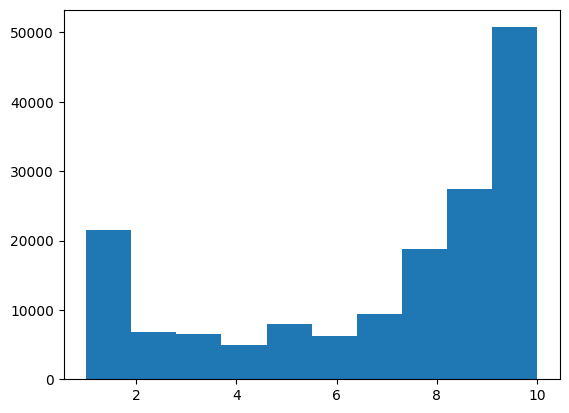

In [20]:
fig, ax =plt.subplots()

ax.hist(trd['rating'])

Ratings are not normally distributed. Counts are highest at the worst and best ratings.

## Data processing

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
yrat = trd.rating
trdd = trd.drop('rating', axis = 1)

In [23]:
rev = trd.review

In [24]:
#from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)


In [25]:
from nltk import FreqDist

creating the distribution frequencies for all invidual items. 

In [26]:
def rowFrs(reviews):
    Frds= []

    for i in trd.review:
        lw= i.lower()
        tkn = tokenizer.tokenize(lw)
        #stopped = [word for word in tkn if word not in stopwords_list]
        Frd= FreqDist(tkn)
        
        Frds.append(Frd)
    return Frds

In [27]:
Frqs= rowFrs(rev)

In [28]:
len(Frqs)

160398

Expand below to include all rows, i.e. creating the frequency distribution for the corpus.

In [29]:
com = trd[0:16000]

In [30]:
comb = ""
for i in com['review']:
    comb += str(i)

In [31]:
comb = comb.lower()

In [32]:
ttestw= tokenizer.tokenize(comb)

In [33]:
from nltk.corpus import stopwords


In [34]:

stopwords_list = stopwords.words('english')
#stopwords_list += list(string.punctuation)
#stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

w_words_stopped = [word for word in ttestw if word not in stopwords_list]

In [35]:
w_words_stoppedC = [word for word in w_words_stopped if '039' not in word]

In [36]:
FD= FreqDist(w_words_stoppedC)

In [37]:
df = pd.DataFrame(data = dict(FD), index = range(16000))

In [38]:
dft=df.transpose()

In [39]:
dft.head()

,0,1,2,3,4,5,6,7,8,9,...,15990,15991,15992,15993,15994,15995,15996,15997,15998,15999
side,5259,5259,5259,5259,5259,5259,5259,5259,5259,5259,...,5259,5259,5259,5259,5259,5259,5259,5259,5259,5259
effect,1066,1066,1066,1066,1066,1066,1066,1066,1066,1066,...,1066,1066,1066,1066,1066,1066,1066,1066,1066,1066
take,4217,4217,4217,4217,4217,4217,4217,4217,4217,4217,...,4217,4217,4217,4217,4217,4217,4217,4217,4217,4217
combination,145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
bystolic,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [40]:
dft.sort_values(by= 0, axis = 0, ascending = False)

,0,1,2,3,4,5,6,7,8,9,...,15990,15991,15992,15993,15994,15995,15996,15997,15998,15999
day,5810,5810,5810,5810,5810,5810,5810,5810,5810,5810,...,5810,5810,5810,5810,5810,5810,5810,5810,5810,5810
side,5259,5259,5259,5259,5259,5259,5259,5259,5259,5259,...,5259,5259,5259,5259,5259,5259,5259,5259,5259,5259
taking,5085,5085,5085,5085,5085,5085,5085,5085,5085,5085,...,5085,5085,5085,5085,5085,5085,5085,5085,5085,5085
years,4649,4649,4649,4649,4649,4649,4649,4649,4649,4649,...,4649,4649,4649,4649,4649,4649,4649,4649,4649,4649
pain,4519,4519,4519,4519,4519,4519,4519,4519,4519,4519,...,4519,4519,4519,4519,4519,4519,4519,4519,4519,4519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lobular,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
peritoneum,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
acknowledged,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ai,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [41]:
df200 =dft.sort_values(by= 0, axis = 0).tail(200)

df200.info()

df200

In [42]:
adic={}
for i in range(len(df200[0])):
    indx =df200.index[i]
    adic[indx]=df200[0][i] 
    


# Data modelling

## Baseline tf-idf model.

Creating the tf-idf matrix.

In [43]:

wtfids = []
for i in range(16000):
    tfidfs =list([])
    for k in adic.keys():
        num = Frqs[i].get(k,0)
        den = adic[k]
        tfidf = num/den
        tfidfs.append(tfidf)
    wtfids.append(tfidfs)

Portioning the y-var (rating)

In [44]:
revscut= trd.rating[0:16000]

In [45]:
yvals = np.asarray(revscut)

In [46]:
xvals = np.asarray(wtfids)

In [47]:
x_train, x_val, y_train,  y_val = train_test_split(xvals, yvals)

In [48]:
from sklearn import linear_model
reg = linear_model.LinearRegression()





In [49]:
reg.fit(x_val, y_val)

LinearRegression()

In [50]:
preds = reg.predict(x_val)

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
mean_squared_error(y_val, preds)

7.694622852699054

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [53]:
from sklearn.tree import DecisionTreeRegressor

Baseline mse is 7.4, scale is 10 points.

In [54]:
regr1 = DecisionTreeRegressor(max_depth = 3)


In [55]:
regr1.fit(x_val, y_val)

DecisionTreeRegressor(max_depth=3)

In [56]:
prds4 = regr1.predict(x_val)

In [57]:
mean_squared_error(y_val, prds4)

9.698681619478217

In [58]:
regr1.decision_path(x_val)

<4000x15 sparse matrix of type '<class 'numpy.int64'>'
	with 16000 stored elements in Compressed Sparse Row format>

In [68]:
regr1.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05806267, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0264676 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25757589,
       0.        , 0.        , 0.        , 0.        , 0.     

In [87]:
len(regr1.feature_importances_)

200

In [104]:
regr1.feature_importances_[93]

0.0

In [103]:
list(adic.keys())[93]

'think'

<BarContainer object of 200 artists>

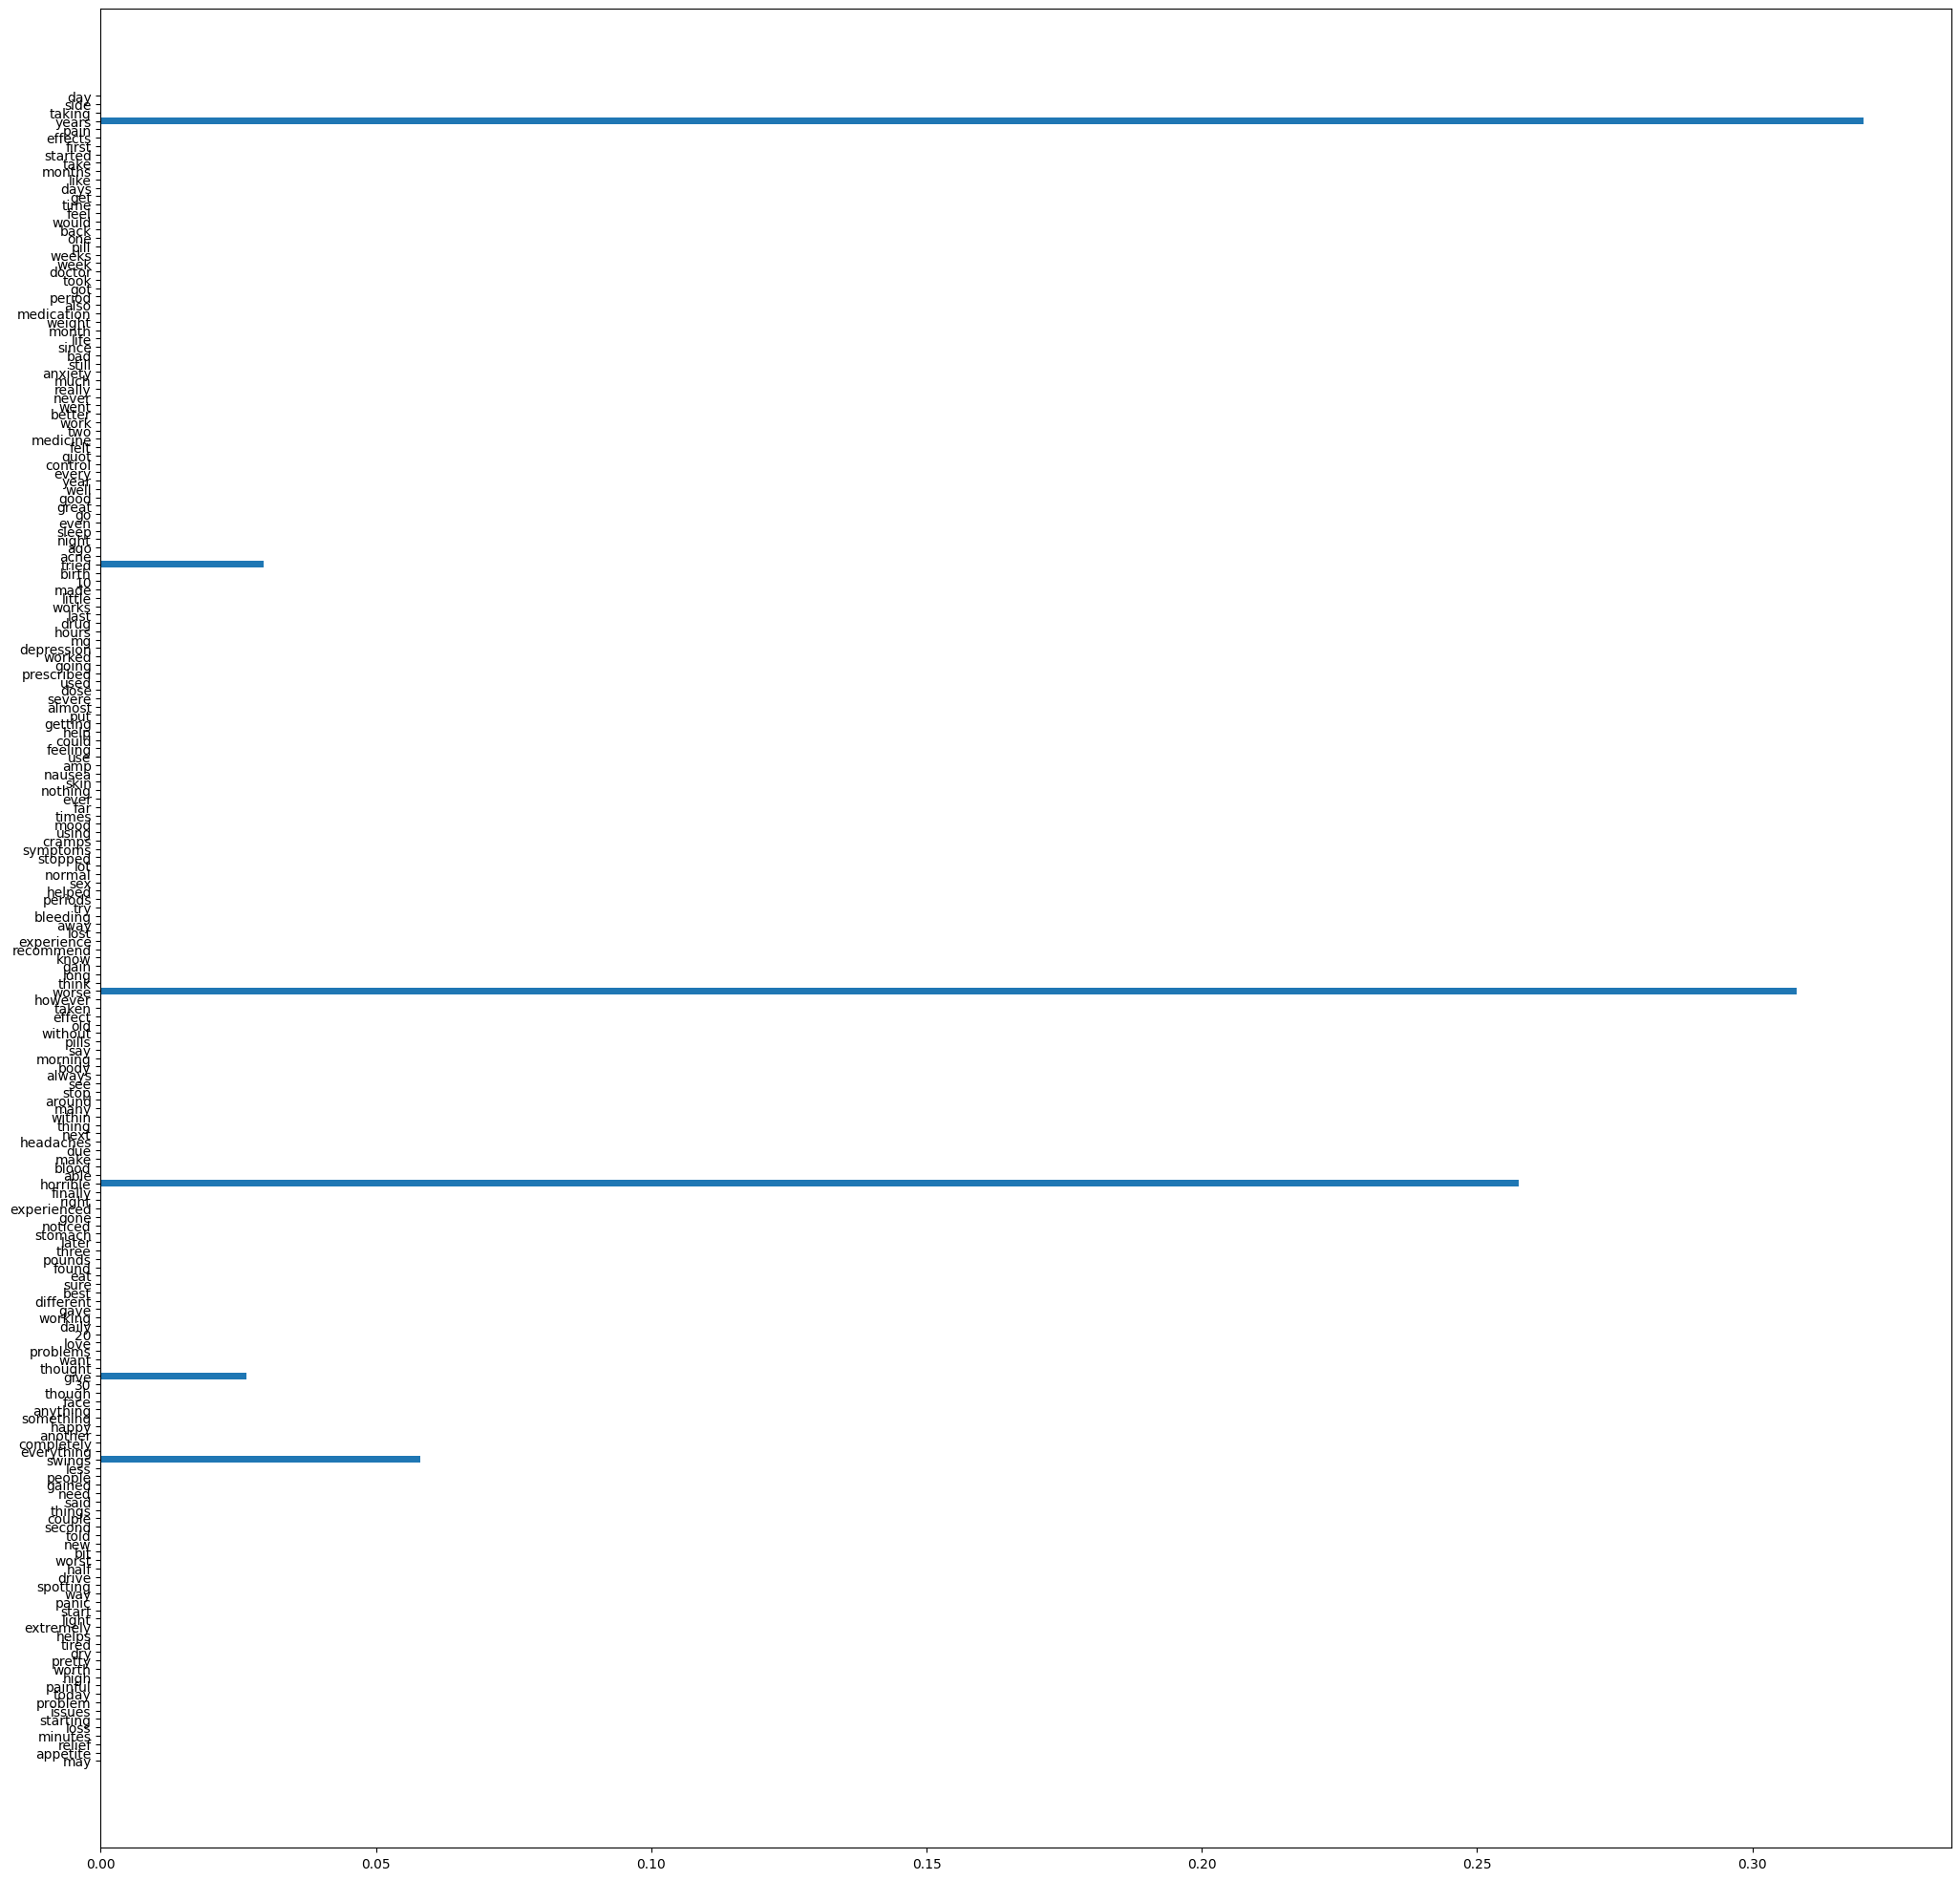

In [109]:
#fig, ax =fig
plt.figure(figsize=(25,25))
plt.barh(list(adic.keys()), regr1.feature_importances_)

Most important features: years, horrible, worse, swings, tired, give

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
rfr = RandomForestRegressor(max_samples = 100)


In [61]:
rfr.fit(x_val, y_val)

RandomForestRegressor(max_samples=100)

In [62]:
prds5 = rfr.predict(x_val)

In [63]:
mean_squared_error(y_val, prds5aa
                   

9.25176842986111

In [65]:
rfr.feature_importance()

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_importance'

## word embeddings, premade

In [70]:
total_vocabulary = set(word for word in w_words_stoppedC)

In [71]:
len(total_vocabulary)

20209

In [72]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [78]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [80]:
t1 = W2vVectorizer(glove)

In [84]:
t1.dimensions

50

In [93]:
t2 = t1.transform(Frqs)

In [95]:
np.shape(t2)

(160398, 50)

In [96]:
ys=trd.rating

In [97]:
reg2 = linear_model.LinearRegression()





In [98]:
reg2.fit(t2, ys)

LinearRegression()

In [99]:
preds2 = reg2.predict(t2)

In [100]:
mean_squared_error(ys, preds2)

9.281641495255512

In [101]:
from sklearn.tree import DecisionTreeRegressor

In [102]:
regr = DecisionTreeRegressor()


In [103]:
regr.fit(t2, ys)

DecisionTreeRegressor()

In [104]:
prds3 = regr.predict(t2)

In [106]:
mean_squared_error(ys, prds3)

0.013698746122637261

In [131]:
regr.feature_importances

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_missing_values_in_feature_mask',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_fit',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_support_missing_values',
 '_validate_X_predict',
 '_validate_data',
 '_validate_params',
 'apply',
 'ccp_alpha',
 

next, ranf, fix tree class. overfit

-Notebook
-README
-data
